In [56]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [71]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('/content/MSFT.csv')
df1=df.reset_index()['Close']

In [72]:
# 3. Scale data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [73]:
# 4. Chia train test
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [74]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [75]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [76]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [77]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [78]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
10/10 [==============================] - 2s 86ms/step - loss: 0.0080 - val_loss: 0.0913
Epoch 2/100
10/10 [==============================] - 1s 53ms/step - loss: 0.0012 - val_loss: 0.0426
Epoch 3/100
10/10 [==============================] - 0s 49ms/step - loss: 8.0408e-04 - val_loss: 0.0331
Epoch 4/100
10/10 [==============================] - 0s 32ms/step - loss: 6.2310e-04 - val_loss: 0.0323
Epoch 5/100
10/10 [==============================] - 0s 27ms/step - loss: 6.0717e-04 - val_loss: 0.0233
Epoch 6/100
10/10 [==============================] - 0s 29ms/step - loss: 5.0862e-04 - val_loss: 0.0251
Epoch 7/100
10/10 [==============================] - 0s 28ms/step - loss: 4.5035e-04 - val_loss: 0.0207
Epoch 8/100
10/10 [==============================] - 0s 30ms/step - loss: 4.2547e-04 - val_loss: 0.0186
Epoch 9/100
10/10 [==============================] - 0s 30ms/step - loss: 4.0666e-04 - val_loss: 0.0161
Epoch 10/100
10/10 [==============================] - 0s 28ms/step - los

In [79]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 7ms/step


In [80]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [81]:
# 12. Tính RMSE, MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mape = np.mean(np.abs((y_pred_val - yval) / yval))
test_mape = np.mean(np.abs((y_pred - ytest) / ytest))

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 257.05514334451726
Testing RMSE: 275.3544831322872
Validation MAE: 255.7723668452202
Testing MAE: 274.0973090297859
Validation MAPE: 376.92895343650366
Testing MAPE: 361.30271648389254


In [84]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=218
i=0
while(i<30):

    if(len(temp_input)>218):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.73938105 0.76857616 0.77307944 0.77025537 0.76037102 0.76792733
 0.7941076  0.78594054 0.80460259 0.81055609 0.80765562 0.80235095
 0.79796216 0.78262033 0.75056295 0.74556353 0.74308293 0.75476097
 0.71369693 0.7027822  0.6941572  0.68843266 0.68434913 0.66778616
 0.6570622  0.67553336 0.67717436 0.69984353 0.70820137 0.65225361
 0.65313136 0.62702749 0.62458502 0.62374542 0.61584553 0.60248828
 0.61023549 0.59855744 0.59676375 0.59279476 0.610579   0.59695458
 0.57939931 0.60931959 0.64038474 0.64160595 0.63240851 0.58451327
 0.56546963 0.55081484 0.55211238 0.58451327 0.56283634 0.59706907
 0.60077094 0.59306188 0.59180247 0.61458613 0.63416406 0.64717785
 0.57336952 0.55592874 0.5907339  0.57646076 0.56134796 0.53054999
 0.50822427 0.53547306 0.56020304 0.5640194  0.54738008 0.6178682
 0.63362977 0.61241084 0.6140137  0.61309775 0.61290692 0.61115143
 0.61431901 0.62569174 0.63542347 0.63508001 0.61321224 0.60775488
 0.66427511 0.66255777 0.66381717 0.6454223  0.6260

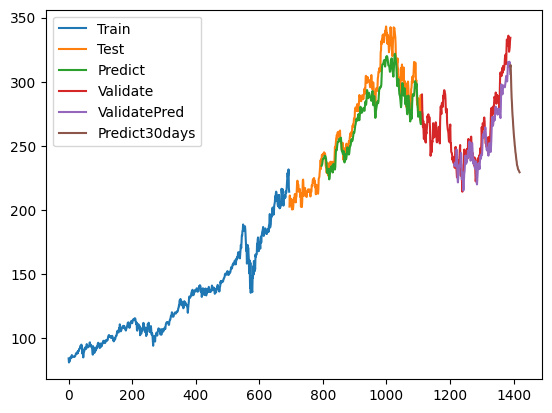

In [85]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')